# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

# Semilla de random state
rs = 12345
# la siguiente línea proporciona gráficos de mejor calidad en pantallas HiDPI
# %config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# esto es para usar progress_apply, puedes leer más en https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Cargar datos

In [4]:
df_reviews = pd.read_csv(
    'https://practicum-content.s3.us-west-1.amazonaws.com/datasets/imdb_reviews.tsv?etag=bbd4a8dc10e6cf1280c42d7350105c41',
    sep='\t', dtype={'votes': 'Int64'})
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


Los datos parecen estar en orden.

## EDA

Veamos el número de películas y reseñas a lo largo de los años.

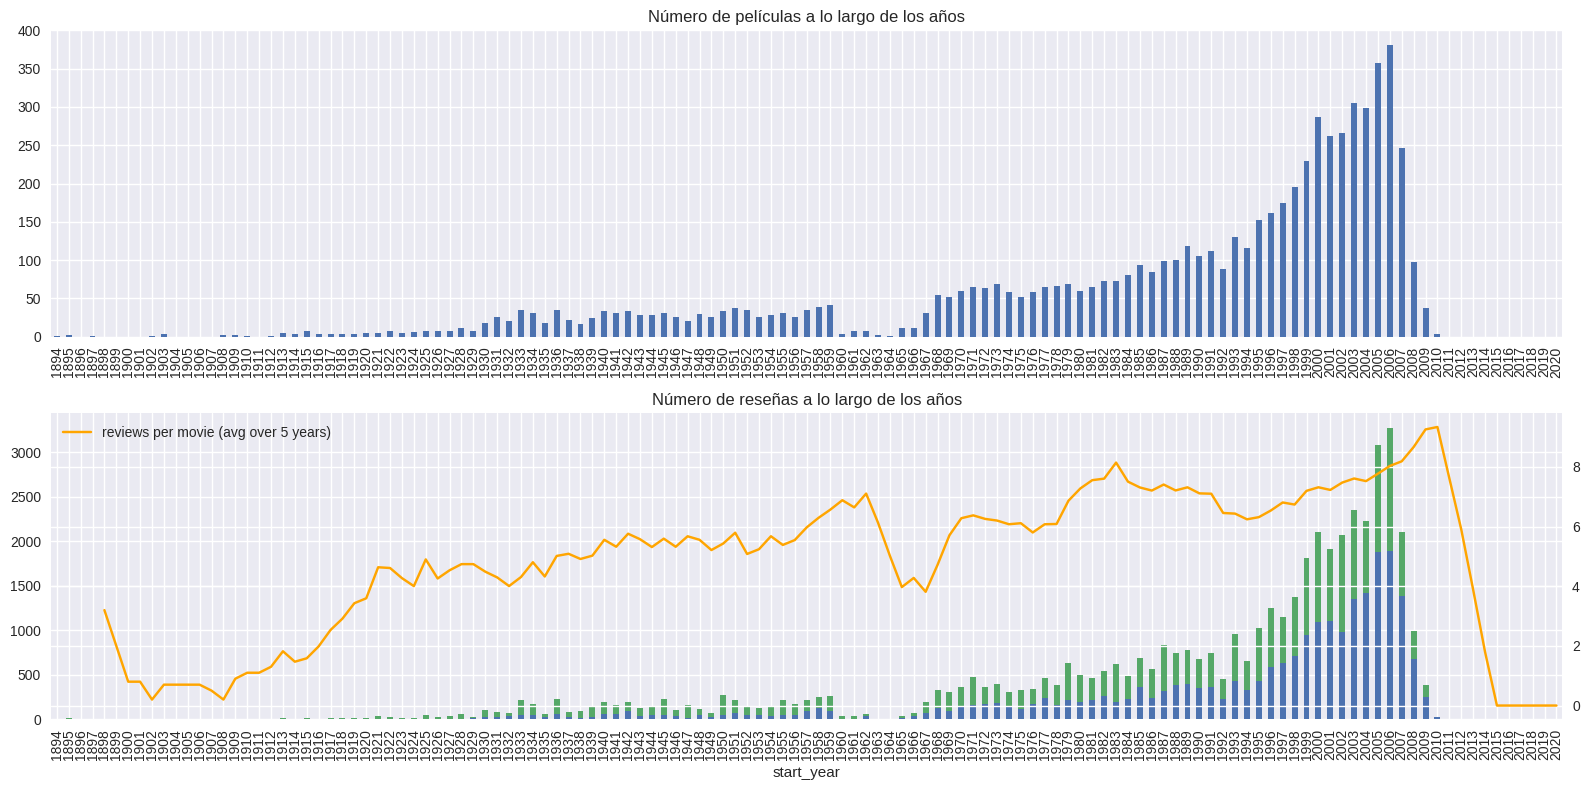

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()

Conclusión: Existe un número creciente de reseñas a lo largo de los años, hasta el año 2006 en el dataset.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

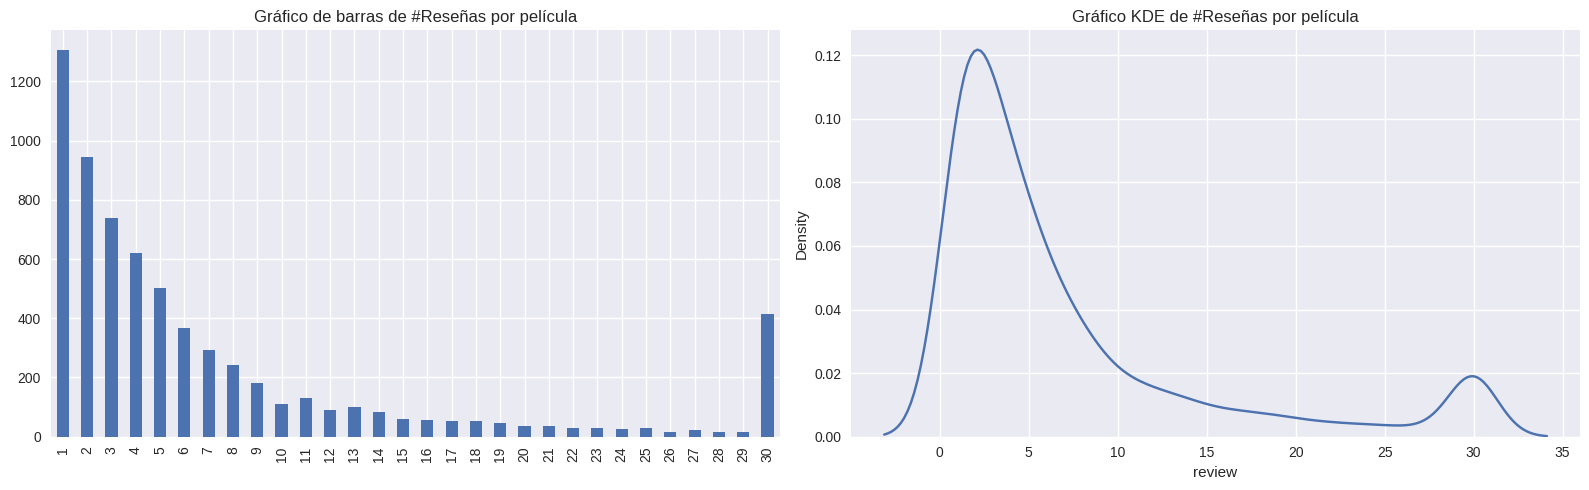

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

Conclusión: La mayoría de películas suelen tener de 1 a 3 reseñas.

In [7]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

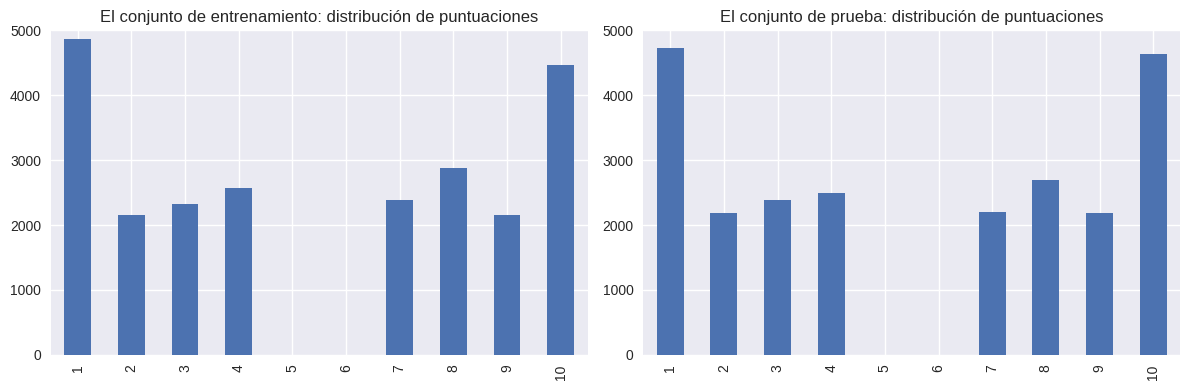

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Conclusión: La mayoría de personas que realizan reseñas suelen dar puntuaciones extremas a las películas. Si una película se considera "promedio" positivamente, se le suele dar un puntaje de 7, en cambio, si se le ve ligeramente de forma negativa, se le suele dar un 3 o 4. No se suelen dar puntajes de 5 o 6 por considerarse inconclusos.

Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


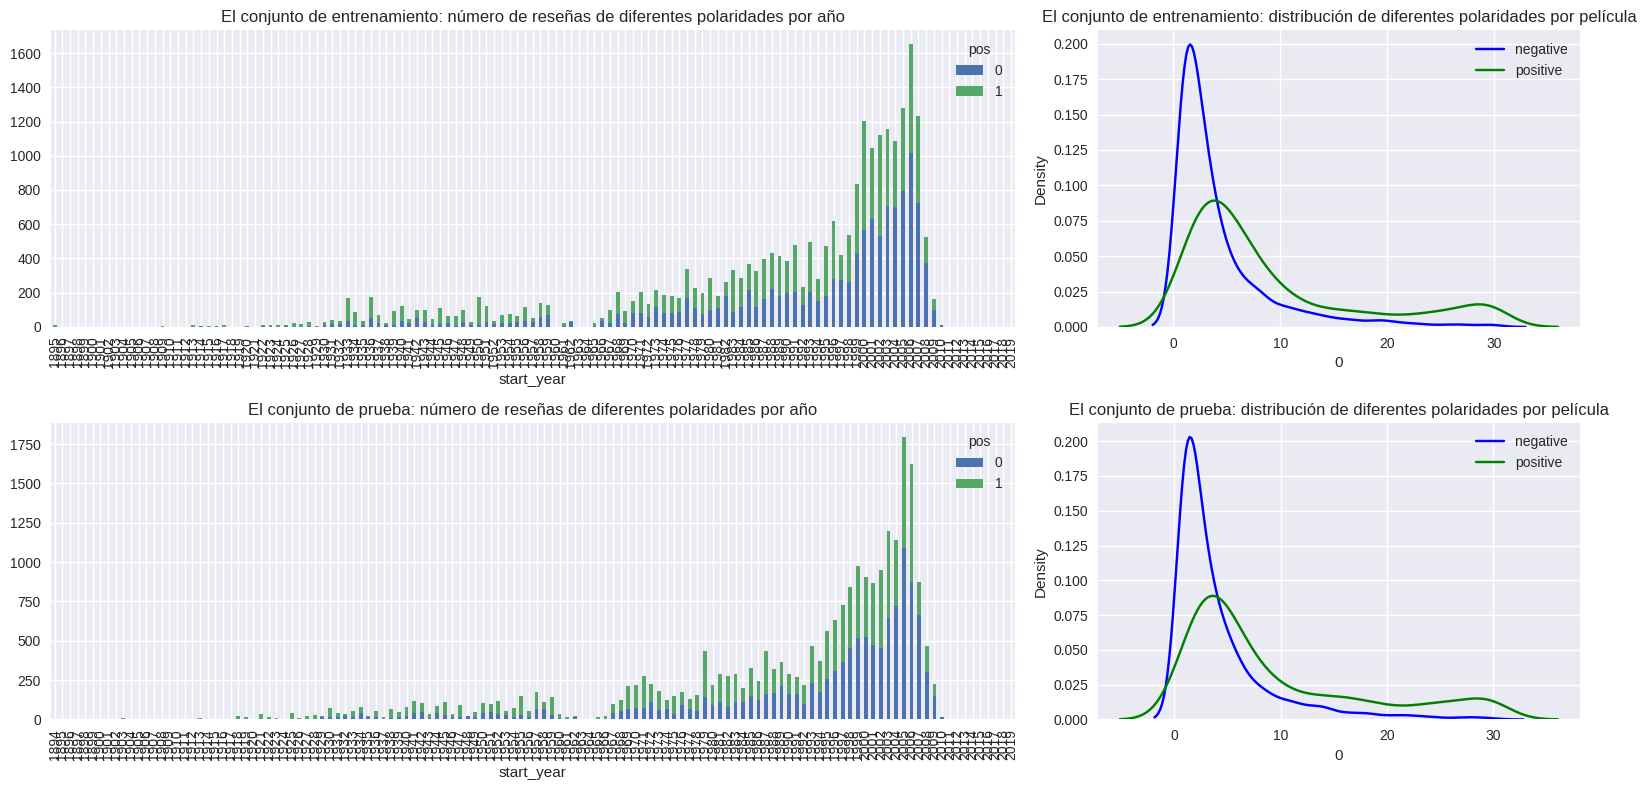

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()

Se suelen dar más reseñas negativas que positivas.

## Procedimiento de evaluación

Composición de una rutina de evaluación que se pueda usar para todos los modelos en este proyecto

In [10]:
import sklearn.metrics as metrics
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Exactitud', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

In [11]:
import re
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clear_text(text):
    pattern = "[^a-zA-Z' ]"
    text2 = re.sub(pattern," ",text)
    text2 = " ".join(text2.split())
    return text2.lower()

def lemmatize(text):
    
    doc = nlp(text.lower())
    
    lemmas = []
    for token in doc:
        lemmas.append(token.lemma_)
        
    return ' '.join(lemmas)

In [12]:
%%time
df_reviews['review_norm'] = df_reviews["review"].apply(clear_text) # <escribe tu código aquí>

CPU times: user 1.1 s, sys: 2.72 ms, total: 1.11 s
Wall time: 1.12 s


In [13]:
%%time
df_reviews["review_lemm"] = df_reviews["review_norm"].apply(lemmatize)

CPU times: user 7min 13s, sys: 3.91 s, total: 7min 17s
Wall time: 7min 22s


In [14]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx,review_norm,review_lemm
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335,the pakage implies that warren beatty and gold...,the pakage imply that warren beatty and goldie...
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336,how the hell did they get this made presenting...,how the hell do they get this make present its...
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489,there is no real story the film seems more lik...,there be no real story the film seem more like...
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280,um a serious film about troubled teens in sing...,um a serious film about troubled teen in singa...
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281,i'm totally agree with garryjohal from singapo...,I be totally agree with garryjohal from singap...


## División entrenamiento / prueba

Por fortuna, todo el conjunto de datos ya está dividido en partes de entrenamiento/prueba; 'ds_part' es el indicador correspondiente.

In [15]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 19)
(23535, 19)


## Trabajar con modelos

### Modelo 0 - Constante

In [16]:
from sklearn.dummy import DummyClassifier

In [17]:
dc_model = DummyClassifier()
dc_model.fit(df_reviews_train,train_target)

DummyClassifier()

           train  test
Exactitud    NaN   NaN
F1           0.0   0.0
APS          0.5   0.5
ROC AUC      0.5   0.5


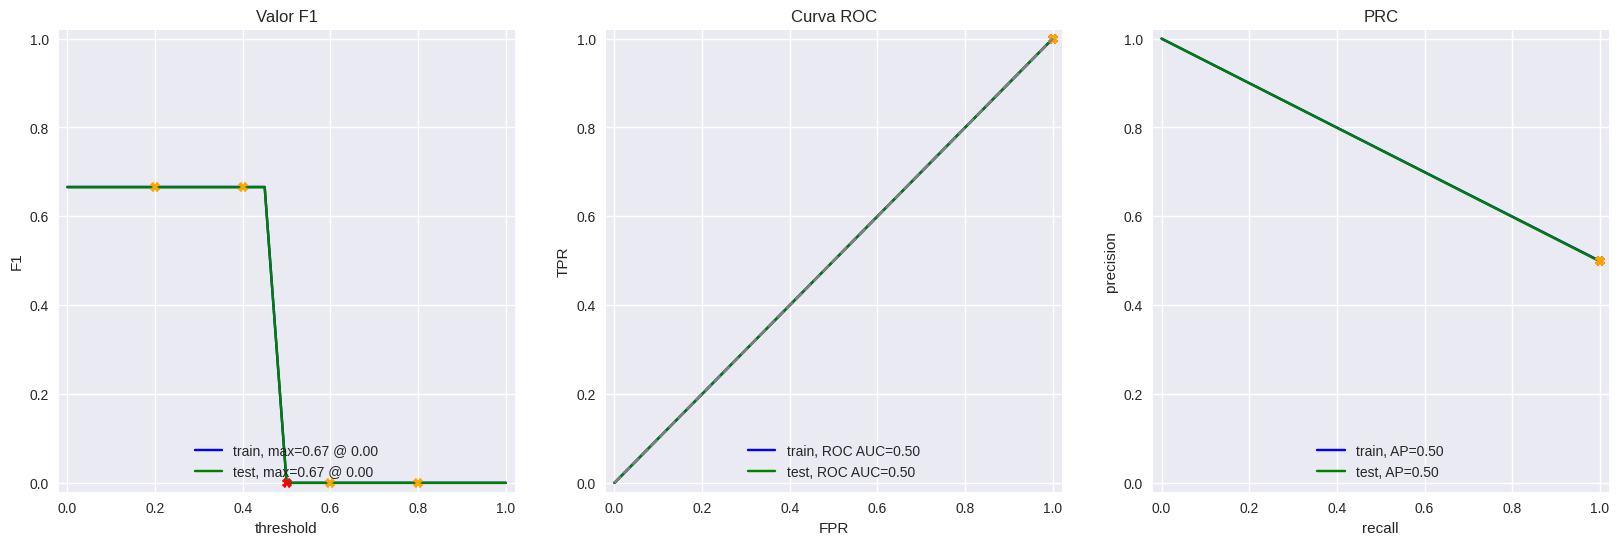

In [18]:
evaluate_model(dc_model,df_reviews_train,train_target,df_reviews_test,test_target)

Conclusión: Este modelo Dummy se usará como base para comparar los demás modelos, por lo que si algún modelo es inferior a este, se le desechará.

### Modelo 1 - NLTK, TF-IDF y LR

TF-IDF

In [19]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [20]:
stop_words = set(stopwords.words("english")) # definir las palabras vacías
count_tf_idf = TfidfVectorizer(stop_words=stop_words) # inicializar TfidVercorizer
tf_idf = count_tf_idf.fit_transform(df_reviews_train["review_norm"]) # ajustar y transformar el corpus de entrenamiento

In [21]:
%%time
lr_1_model = LogisticRegression().fit(tf_idf,train_target)

CPU times: user 1.46 s, sys: 3 s, total: 4.46 s
Wall time: 4.45 s


           train  test
Exactitud    NaN   NaN
F1          0.94  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


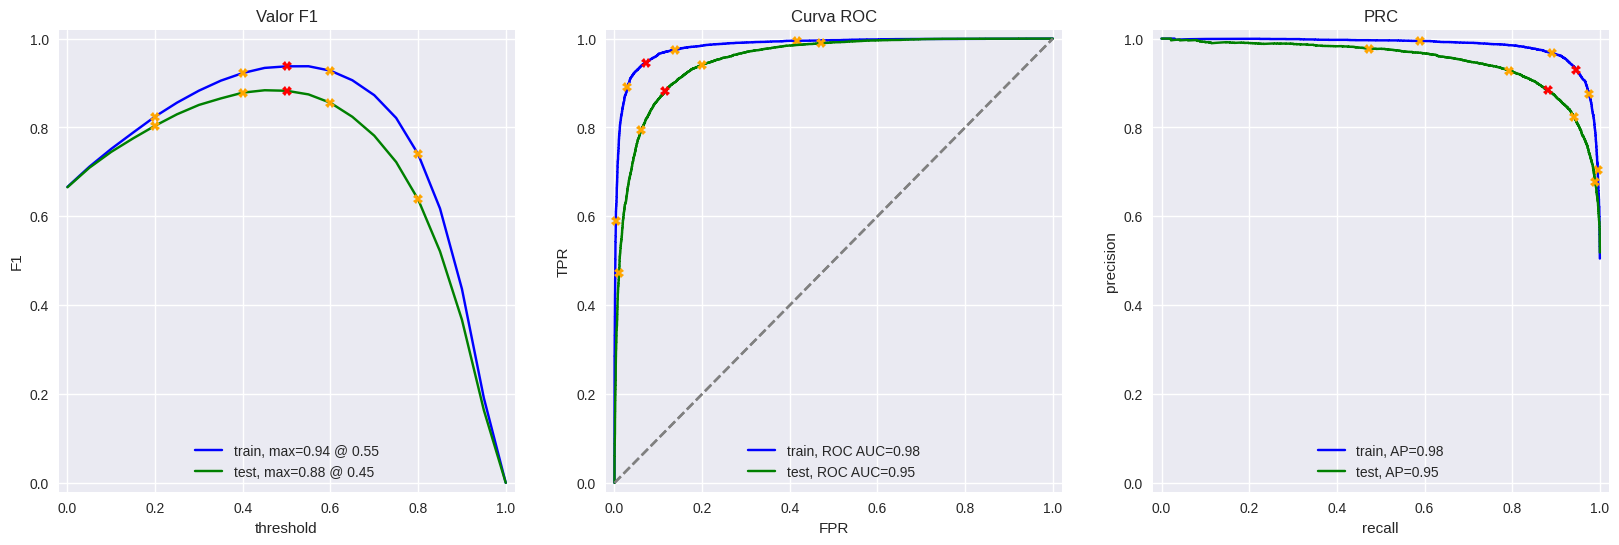

In [22]:
evaluate_model(lr_1_model, tf_idf, train_target, count_tf_idf.transform(df_reviews_test["review_norm"]), test_target)

Conclusión: La regresión logística sin lematización desempeña bastante bien y supera el valor mínimo buscado de F1 de 0.85.

### Modelo 3 - spaCy, TF-IDF y LR

In [23]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [24]:
# La función Lemmatize ya se encarga de este proceso.
#def text_preprocessing_3(text):
    
#    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
#    tokens = [token.lemma_ for token in doc]
    
#    return ' '.join(tokens)

In [25]:
count_tf_idf2 = TfidfVectorizer(stop_words=stop_words) # inicializar TfidVercorizer
features_train = count_tf_idf2.fit_transform(df_reviews_train["review_lemm"])
features_test = count_tf_idf2.transform(df_reviews_test["review_lemm"])

In [26]:
lr_2_model = LogisticRegression().fit(features_train,train_target) # inicializar el modelo de regresión logística y ajustarlo

           train  test
Exactitud    NaN   NaN
F1          0.93  0.88
APS         0.98  0.95
ROC AUC     0.98  0.95


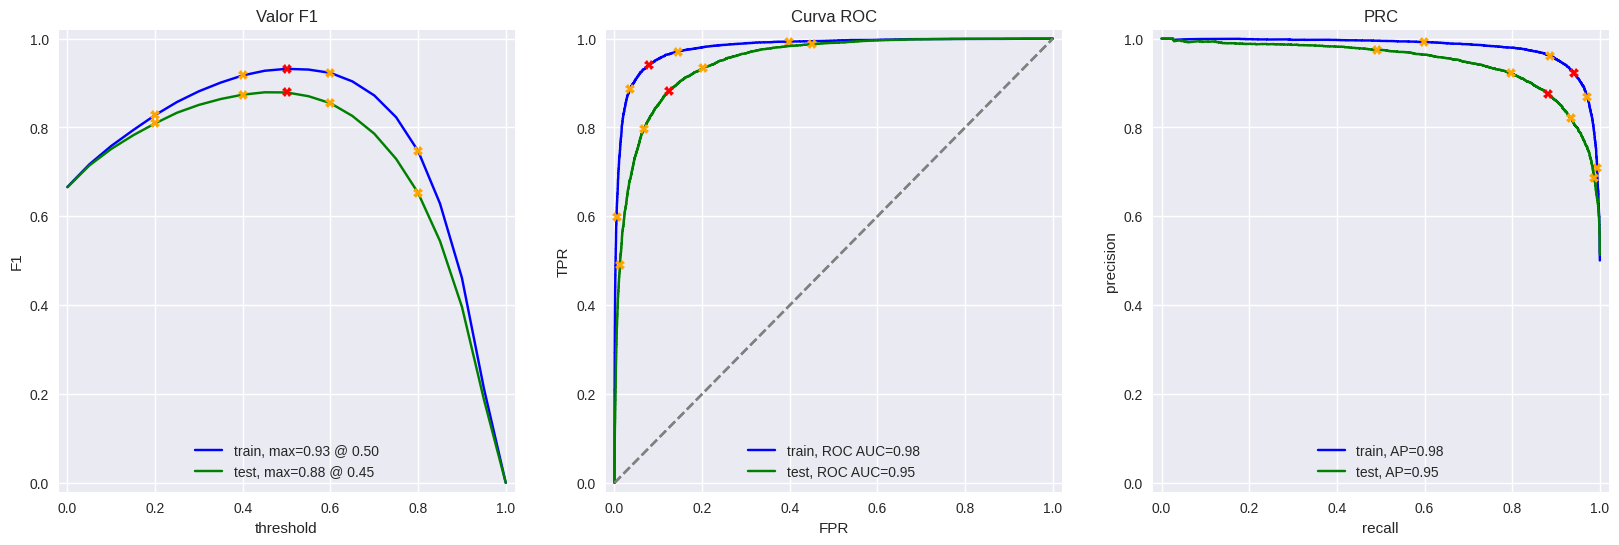

In [27]:
evaluate_model(lr_2_model, features_train, train_target, features_test, test_target)

Conclusión: La regresión logística con lematización también tiene un desempeño favorable y también supera el valor mínimo buscado de F1 de 0.85.

### Modelo 4 - spaCy, TF-IDF y LGBMClassifier

In [28]:
from lightgbm import LGBMClassifier

In [29]:
lgb_best_score = float("-inf")
lgb_best_depth = 0
lgb_best_model = None

In [30]:
%%time
# Seleccionamos el rango del hiperparámetro.
for depth in range(20,50,5):
    
    # Iniciamos el constructor.
    lgb_model = LGBMClassifier(random_state=rs, max_depth = depth)
    
    # Entrenamos el modelo en el conjunto de entrenamiento.
    lgb_model.fit(features_train, train_target)
    
    # Realizamos predicciones en el conjunto de validación
    lgb_preds = lgb_model.predict(features_test)
    
    # Calculamos la exactitud.
    #score = model.score(features_val,target_val)
    
    # Calculamos el RMSE
    #lgb_score = mean_squared_error(test_target,lgb_preds) ** 0.5
        
    # Calculamos el F1 score
    lgb_score = metrics.f1_score(test_target,lgb_preds)
    
    # Guardamos la cantidad de estimadores que generaron el mejor puntaje.
    if lgb_score > lgb_best_score:
        lgb_best_model = lgb_model
        lgb_best_score = lgb_score
        lgb_best_depth = depth

print("El F1 del mejor modelo en el conjunto de validación (max_depth = {}): {}".format(
    lgb_best_depth, lgb_best_score))

El F1 del mejor modelo en el conjunto de validación (max_depth = 25): 0.8585559688873858
CPU times: user 3min 1s, sys: 581 ms, total: 3min 1s
Wall time: 3min 3s


           train  test
Exactitud    NaN   NaN
F1          0.91  0.86
APS         0.97  0.93
ROC AUC     0.97  0.94


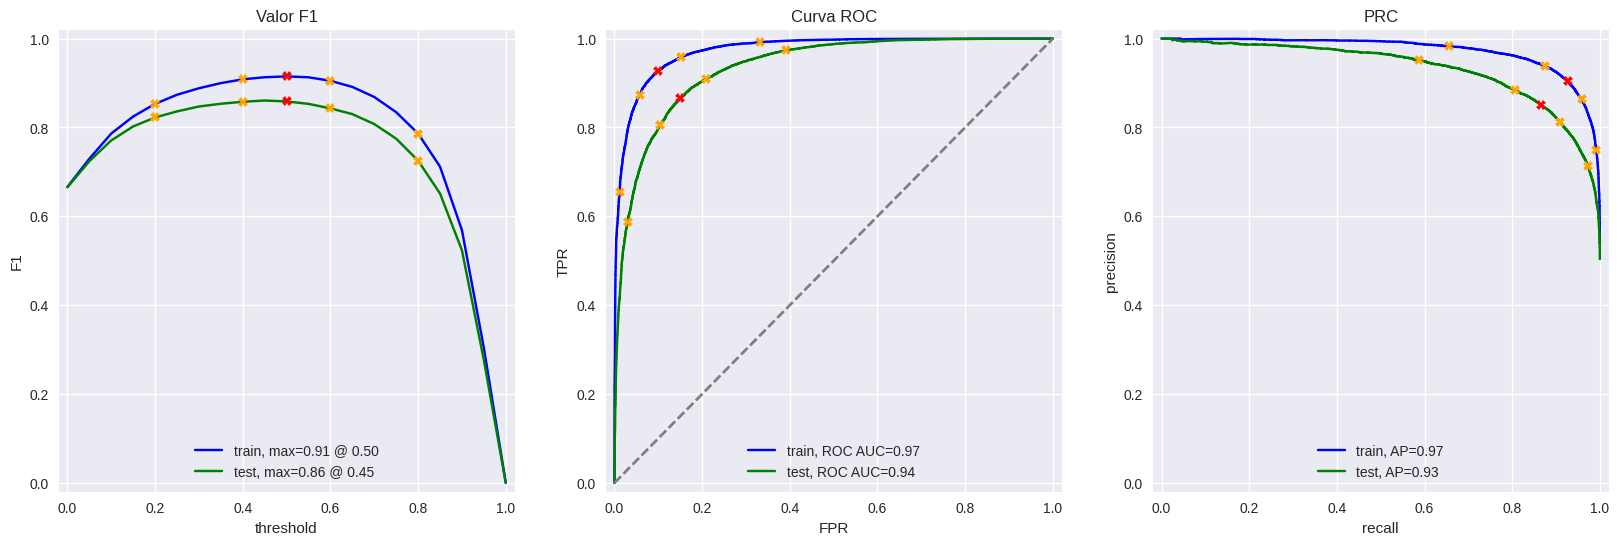

In [31]:
evaluate_model(lgb_best_model, features_train, train_target, features_test, test_target)

Conclusión: El modelo con LGBM también desempeña favorablemente y supera el valor mínimo buscado de F1 de 0.85. Sin embargo, tiene un desempeño ligeramente menor que la regresión logística.

###  Modelo 9 - BERT

Nota: Se entrenará el modelo BERT con una muestra de 50 casos debido al alto tiempo de procesamiento y la falta de un GPU Nvidia en mi sistema.

In [32]:
import torch
import transformers

In [33]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
def BERT_text_to_embeddings(texts, target=None, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
       
    # <escribe tu código aquí para crear ids_list y attention_mask_list>
    for input_text in texts:
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    # obtener insertados en lotes
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <escribe tu código aquí para crear attention_mask_batch
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
    if target is not None:
        lr_model = LogisticRegression()
        lr_model.fit(np.concatenate(embeddings),target)
        
        return lr_model, np.concatenate(embeddings)
    return np.concatenate(embeddings)

In [35]:
data_train = df_reviews_train['review_norm'].sample(50,random_state=rs)
data_target_train = df_reviews_train["pos"].loc[data_train.index]

In [ ]:
# ¡Atención! La ejecución de BERT para miles de textos puede llevar mucho tiempo en la CPU, al menos varias horas

bert_model, train_features_9 = BERT_text_to_embeddings(data_train, data_target_train, force_device=None)#force_device='cuda')

Uso del dispositivo cpu.


  0%|          | 0/1 [00:00<?, ?it/s]

/tmp/ipykernel_115/533222663.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)


In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# si ya obtuviste los insertados, te recomendamos guardarlos para tenerlos listos si
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# y cargar...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

Conclusión: El modelo BERT fue entrenado exitosamente.

## Mis reseñas

In [32]:
# puedes eliminar por completo estas reseñas y probar tus modelos en tus propias reseñas; las que se muestran a continuación son solo ejemplos

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews["review"].apply(clear_text) # <escribe aquí la misma lógica de normalización que para el conjunto de datos principal>
my_reviews["review_lemm"] = my_reviews["review_norm"].apply(lemmatize)

my_reviews

,review,review_norm,review_lemm
0,"I did not simply like it, not my kind of movie.",i did not simply like it not my kind of movie,I do not simply like it not my kind of movie
1,"Well, I was bored and felt asleep in the middl...",well i was bored and felt asleep in the middle...,well I be bored and feel asleep in the middle ...
2,I was really fascinated with the movie,i was really fascinated with the movie,I be really fascinated with the movie
3,Even the actors looked really old and disinter...,even the actors looked really old and disinter...,even the actor look really old and disinterest...
4,I didn't expect the reboot to be so good! Writ...,i didn't expect the reboot to be so good write...,I do not expect the reboot to be so good write...
5,"The movie had its upsides and downsides, but I...",the movie had its upsides and downsides but i ...,the movie have its upside and downside but I f...
6,What a rotten attempt at a comedy. Not a singl...,what a rotten attempt at a comedy not a single...,what a rotten attempt at a comedy not a single...
7,Launching on Netflix was a brave move & I real...,launching on netflix was a brave move i really...,launch on netflix be a brave move I really app...


### Modelo 2

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = lr_1_model.predict_proba(count_tf_idf.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.14:  i did not simply like it not my kind of movie
0.16:  well i was bored and felt asleep in the middle of the movie
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested and they got paid to be in the movie what a soul
0.31:  i didn't expect the reboot to be so good writers really cared about the source material
0.47:  the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myse
0.04:  what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids 
0.82:  launching on netflix was a brave move i really appreciate being able to binge on episode after episo


### Modelo 3

In [34]:
texts = my_reviews['review_lemm']

my_reviews_pred_prob = lr_2_model.predict_proba(
    count_tf_idf2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.20:  I do not simply like it not my kind of movie
0.12:  well I be bored and feel asleep in the middle of the movie
0.49:  I be really fascinated with the movie
0.10:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.27:  I do not expect the reboot to be so good writer really care about the source material
0.50:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.03:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.92:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo 4

In [35]:
texts = my_reviews['review_lemm']

tfidf_vectorizer_4 = count_tf_idf2
my_reviews_pred_prob = lgb_best_model.predict_proba(tfidf_vectorizer_4.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.61:  I do not simply like it not my kind of movie
0.37:  well I be bored and feel asleep in the middle of the movie
0.60:  I be really fascinated with the movie
0.37:  even the actor look really old and disintereste and they get pay to be in the movie what a soulless 
0.65:  I do not expect the reboot to be so good writer really care about the source material
0.72:  the movie have its upside and downside but I feel like overall it be a decent flick I could see myse
0.27:  what a rotten attempt at a comedy not a single joke land everyone act annoying and loud even kid wil
0.75:  launch on netflix be a brave move I really appreciate be able to binge on episode after episode of t


### Modelo 9

In [36]:
texts = my_reviews['review_norm']
targets = train_target[df_reviews_train['review_norm'].sample(50,random_state=rs).index]

my_reviews_features_9 = BERT_text_to_embeddings(texts, target=None, disable_progress_bar=True)

my_reviews_pred_prob = bert_model.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

NameError: name 'BERT_text_to_embeddings' is not defined

Conclusión: Los modelos generan predicciones de forma satisfactoria.

## Conclusiones

En el presente proyecto se entrenaron varios modelos para analizar el sentimiento de varias reseñas de películas. El valor mínimo buscado en puntaje F1 es de 0.85. Los resultados de los modelos son los siguientes:

| Modelo | F1 |
|---|---|
| Regresión Logística sin Lematización | 0.88 |
| Regresión Logística con Lematización | 0.88 |
| Árbol potenciado por gradiente LGBM | 0.86 |

Por lo que los modelos de regresión logística han mostrado ser ligeramente superiores para esta tarea en específico.

También se entrenó un modelo con BERT. Sin embargo, debido a limitaciones en la capacidad de procesamiento del equipo, no se logró entrenar con todo el conjunto de datos.

Esperamos seguir contando con su confianza para el desarrollo de más modelos.